In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy.spatial.distance import cdist
from scipy.special import kl_div, gamma, gammaln, digamma
import itertools
from tqdm import tqdm

In [2]:
%config InlineBackend.figure_format='retina'
%matplotlib inline
%load_ext autoreload
%autoreload 2

# The ball own force is a GP with a squared exponential kernel

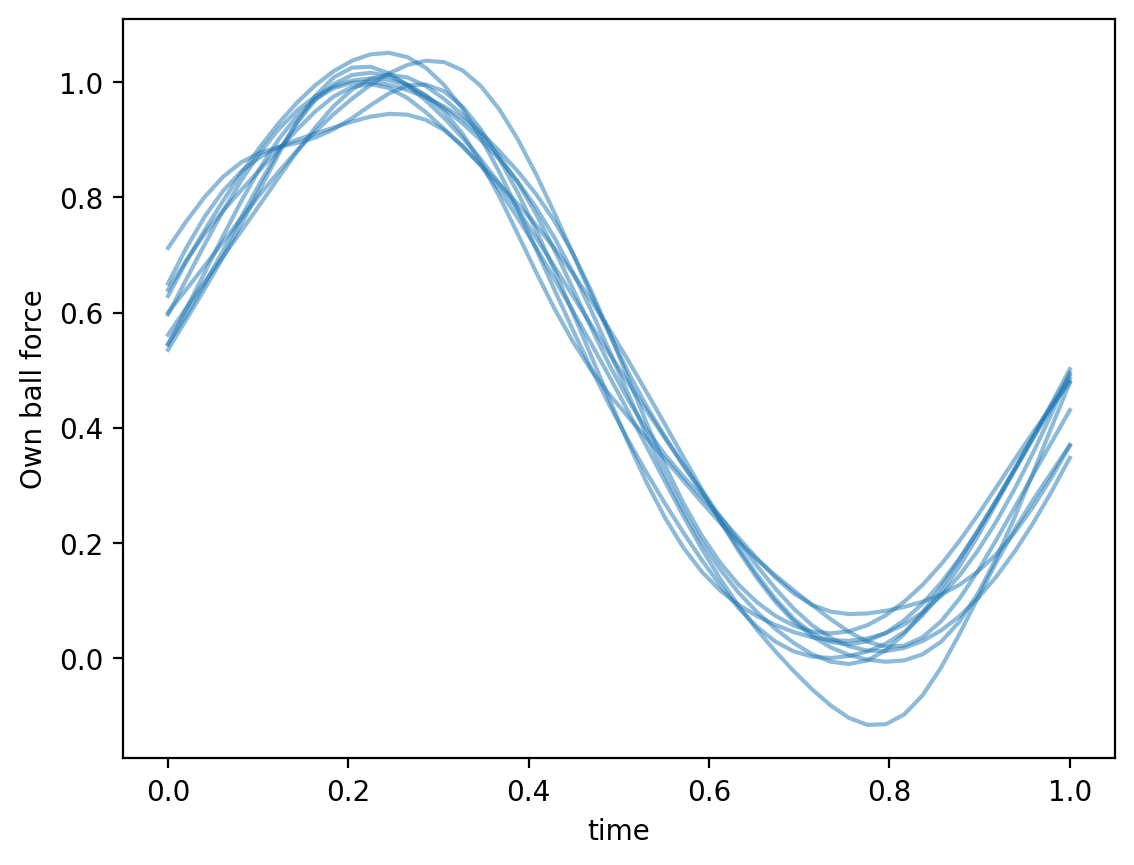

In [3]:
x = np.linspace(0, 1.0, 50)
mu = 0.5 + 0.5*np.cos(6*(x + 5))

alpha = 0.05
length = 0.1

x2d = x.reshape((-1, 1))
sigma = alpha**2 * np.exp(-0.5 * cdist(x2d, x2d, 'sqeuclidean')/length**2)

n_sample = 10
y = np.random.multivariate_normal(mu, sigma, n_sample)

n_sample = 10
fig, ax = plt.subplots()
for y_ in y:
    ax.plot(x, y_, color="C0", alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("Own ball force");

# The effect of pushing the ball is a GP with a squared exponential kernel

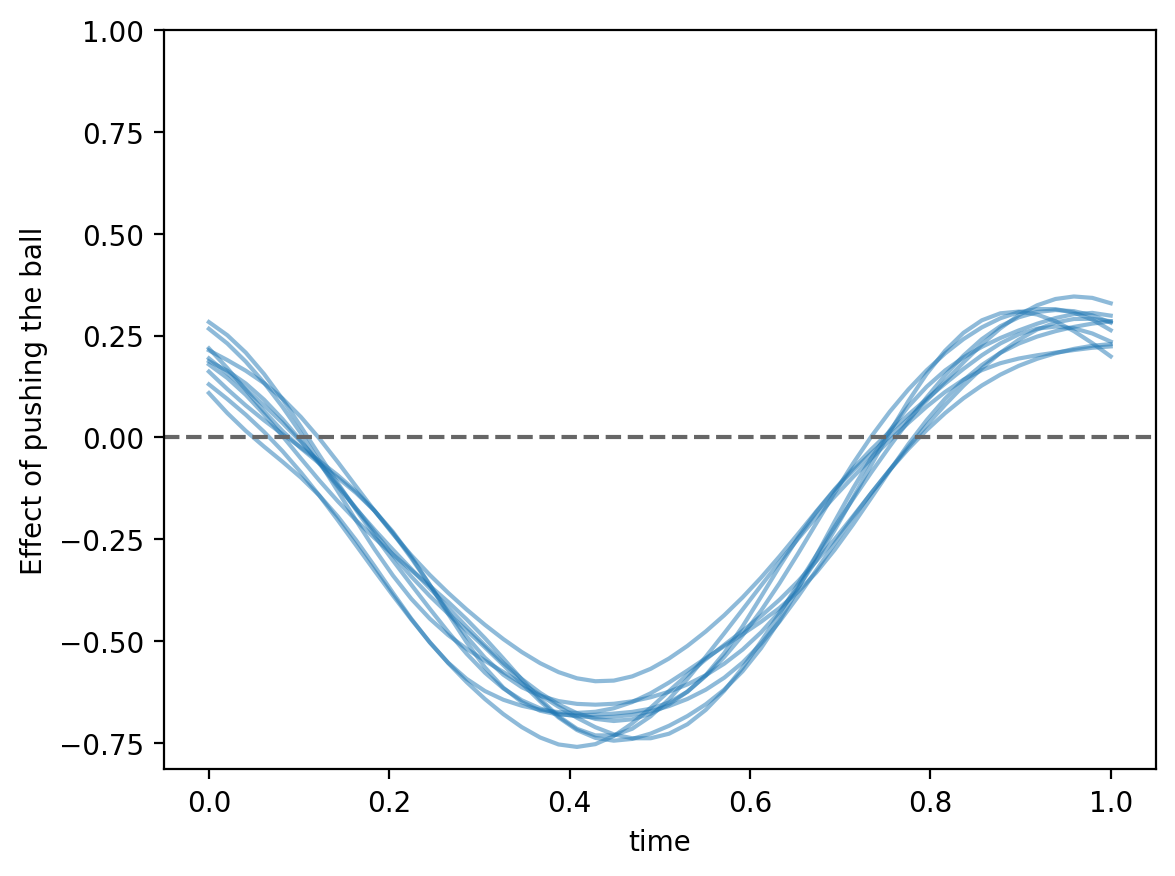

In [4]:
x = np.linspace(0, 1.0, 50).reshape((-1, 1))
mu = - 0.2 + 0.5*np.cos(6*(np.squeeze(x) - 2))

alpha = 0.05
length = 0.1

sigma = alpha**2 * np.exp(-0.5 * cdist(x, x, 'sqeuclidean')/length**2)

n_sample = 10
y = np.random.multivariate_normal(mu, sigma, n_sample)
fig, ax = plt.subplots()
for y_ in y:
    ax.plot(x, y_, color="C0", alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("Effect of pushing the ball")
ax.set_ylim(None, 1);
ax.axhline(y=0.0, ls="--", color="0.4");

# Running the ball environment

In [5]:
class Ball:
    def __init__(self, n_step):
        
        self.state = np.zeros(2)
        
        self.n_step = n_step
        self.x = np.linspace(0, 1.0, self.n_step)
        
        self.min_position, self.max_position = 0.0, 200.0
        self.max_speed = 10.0 
        
        self.friction_factor = 0.5
        
        self.own_force = None
        self.action_effect = None
        self.current_step = None

    @staticmethod
    def square_exponential_kernel(x, alpha, length):
        return alpha**2 * np.exp(-0.5 * cdist(x.reshape(-1, 1), x.reshape(-1, 1), 'sqeuclidean')/length**2)
    
    def sample_action_effect(self):
        
        x = self.x
        mu = - 0.2 + 0.5*np.cos(6*(x - 2))
        alpha = 0.05
        length = 0.1 
        sigma = self.square_exponential_kernel(x, alpha, length)
        return np.random.multivariate_normal(mu, sigma)
    
    def sample_own_force(self):
        
        x = self.x
        mu = 0.5 + 0.5*np.cos(6*(x + 5))
        alpha = 0.05
        length = 0.1
        sigma = self.square_exponential_kernel(x, alpha, length)
        return np.random.multivariate_normal(mu, sigma)

    def step(self, action: int):

        position, velocity = self.state

        velocity -= self.friction_factor * velocity
        velocity += self.action_effect[self.current_step]*action
        velocity += self.own_force[self.current_step]
        
        velocity = np.clip(velocity, -self.max_speed, self.max_speed)

        dt = (1./self.n_step)
        position += dt*velocity
        position = np.clip(position, self.min_position, self.max_position)
        
        self.state = position, velocity
        self.current_step += 1
        if self.current_step > self.n_step:
            raise ValueError("This wasn't supposed to be a step")
            
        return self.state
        
    def reset(self, seed=None):
                    
        if seed is not None:
            np.random.seed(seed)
            
        self.own_force = self.sample_own_force()
        self.action_effect = self.sample_action_effect()
        self.current_step = 0
        

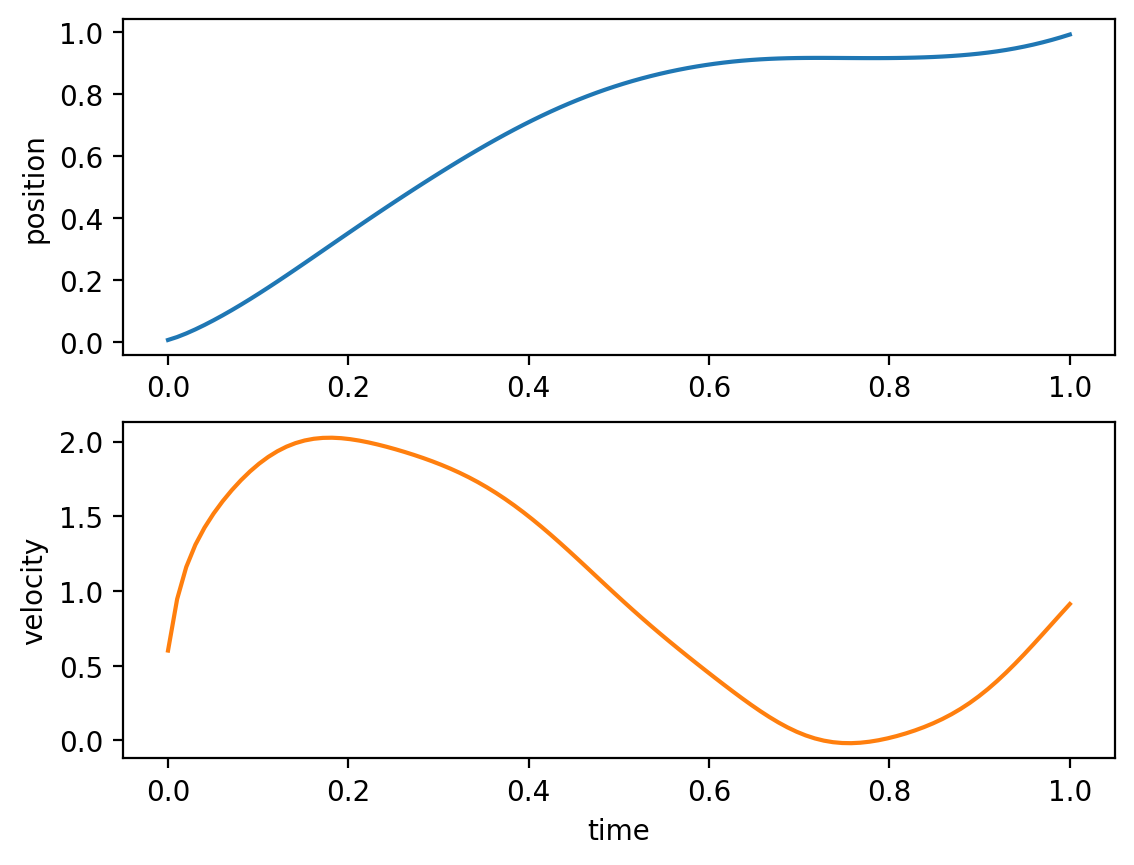

In [6]:
n_step = 100
ball = Ball(n_step)
ball.reset(seed=123456)
hist_pos, hist_vel = [], []
for i in range(n_step):
    pos, vel = ball.step(action=0)
    hist_pos.append(pos)
    hist_vel.append(vel)

_, axes = plt.subplots(nrows=2)
x = np.linspace(0, 1, n_step)
axes[0].plot(x, hist_pos)
axes[0].set_ylabel("position")
axes[1].plot(x, hist_vel, color="C1")
axes[1].set_ylabel("velocity")
axes[1].set_xlabel("time");

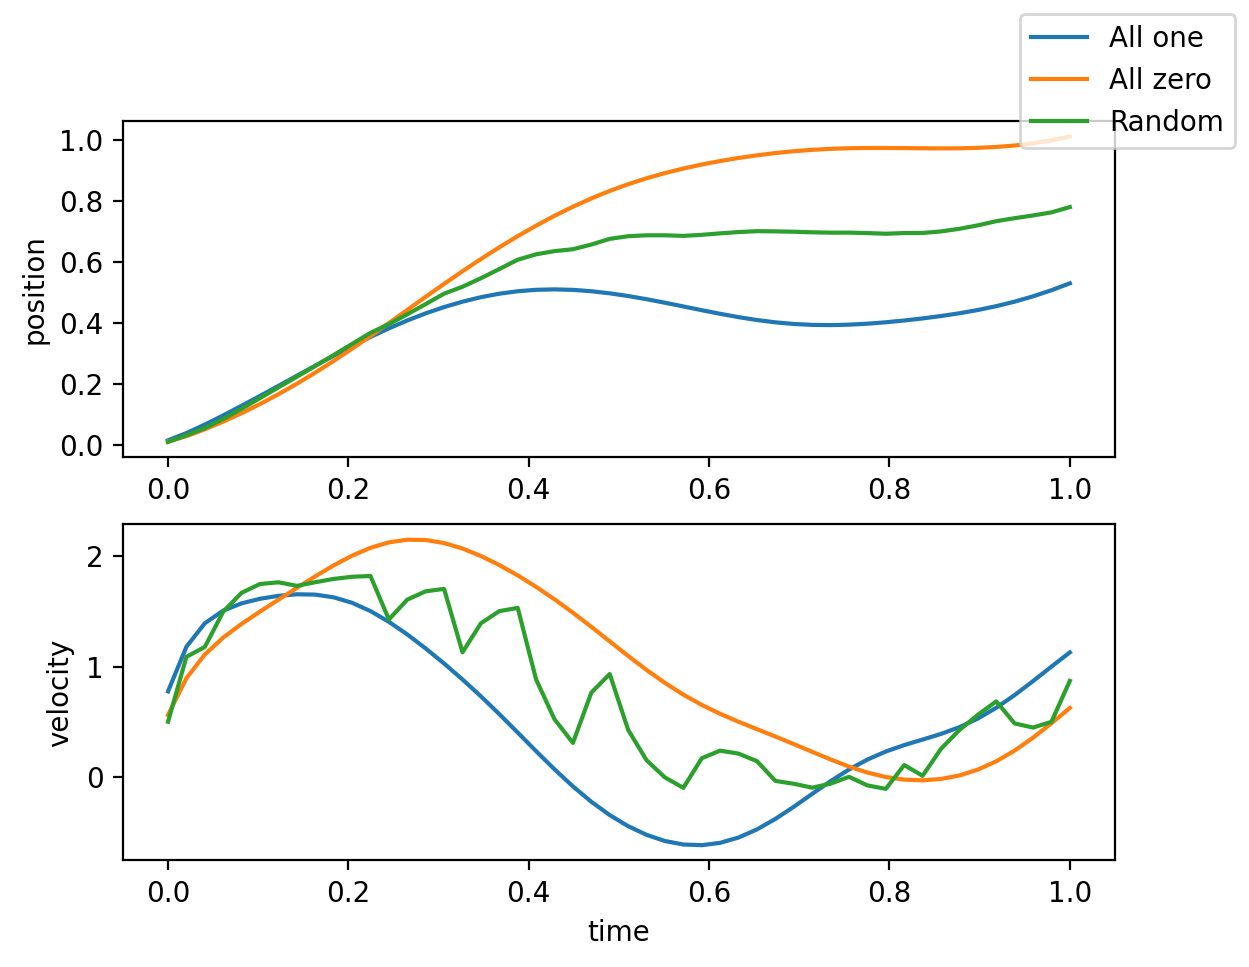

In [7]:
n_step = 50
all_hist_pos = []
all_hist_vel = []

policies = "all-one", "all-zero", "random"

for policy in policies:
    
    ball = Ball(n_step)
    ball.reset()
    hist_pos, hist_vel = [], []
    for i in range(n_step):
        if policy == "all-one":
            action = 1
        elif policy == "all-zero":
            action = 0
        elif policy == "random":
            action = np.random.choice([0, 1])
        else:
            raise ValueError
        pos, vel = ball.step(action=action)
        hist_pos.append(pos)
        hist_vel.append(vel)
        
    all_hist_pos.append(hist_pos)
    all_hist_vel.append(hist_vel)

fig, axes = plt.subplots(nrows=2)
for i in range(len(policies)):
    label = policies[i].replace("-", " ").capitalize()
    pos = all_hist_pos[i]
    vel = all_hist_vel[i]
    x = np.linspace(0, 1, n_step)
    axes[0].plot(x, pos, color=f"C{i}", label=label)
    axes[1].plot(x, vel, color=f"C{i}")
    axes[0].set_ylabel("position")
    axes[1].set_ylabel("velocity");
    axes[1].set_xlabel("time");
    
    
fig.legend();

# Moving to a discrete world

In [8]:
def square_exponential_kernel(x, alpha, length):
    return alpha**2 * np.exp(-0.5 * cdist(x.reshape(-1, 1), x.reshape(-1, 1), 'sqeuclidean')/length**2)

def sample_action_effect(t, size=1):

    mu = - 0.2 + 0.5*np.cos(6*(t - 2))
    alpha = 0.05
    length = 0.1
    sigma = square_exponential_kernel(t, alpha, length)
    return np.random.multivariate_normal(mu, sigma, size=size)

def sample_own_force(t, size=1):

    mu = 0.5 + 0.5*np.cos(6*(t + 5))
    alpha = 0.05
    length = 0.1
    sigma = square_exponential_kernel(t, alpha, length)
    return np.random.multivariate_normal(mu, sigma, size=size)

In [9]:
n_timestep = 6
n_velocity = 20
n_action = 2

timestep = np.linspace(0, 1.0, n_timestep)
velocity = np.linspace(-1., 3.0, n_velocity)
action = np.arange(n_action)

max_velocity = 10.0
friction_factor = 0.5

n_sample = 300

## Building the velocity transaction matrix

In [10]:
own_force = sample_own_force(timestep, size=n_sample)
action_effect = sample_action_effect(timestep, size=n_sample)

In [11]:
space = [(v, t) for t in timestep for v in velocity]
size_space = len(space)
velocity_list = list(velocity) # Used for easily find index of velocity

In [12]:
# Compute 'true' transition probabilities
timestep_list = list(timestep)

transition_velocity_sav = np.zeros((size_space, n_action, n_velocity))
transition_velocity_tvav = np.zeros((n_timestep, n_velocity, n_action, n_velocity))
transition_velocity_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity))
for i, (v, t) in enumerate(space):
    t_index = timestep_list.index(t)
    for a in action:
        new_v = np.zeros(n_sample)
        new_v += v - friction_factor*v
        new_v += action_effect[:, t_index]*a
        new_v += own_force[:, t_index]
        new_v = np.clip(new_v, -max_velocity, max_velocity)
        hist, bins = np.histogram(
            new_v,
            bins=list(velocity) + [velocity[-1] + (velocity[-1] - velocity[-2])])
        density = hist / np.sum(hist)
        transition_velocity_sav[i, a, :] = density
        transition_velocity_tvav[t_index, velocity_list.index(v), a, :] = density
        transition_velocity_tavv[t_index, a, velocity_list.index(v), :] = density

#### Visualizing the velocity transition matrix

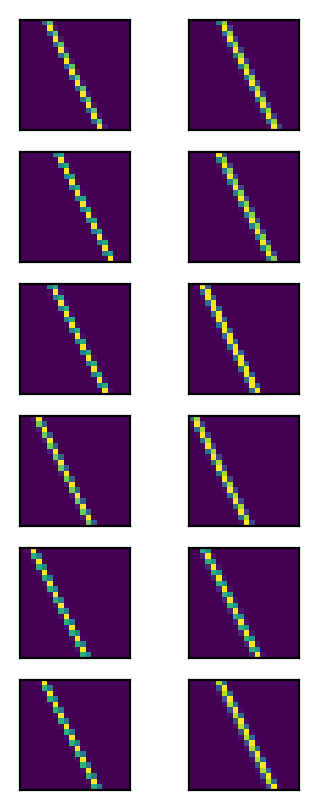

In [13]:
fig, axes = plt.subplots(ncols=n_action, nrows=n_timestep, figsize=(2, 5))
for i in range(n_action):
    for j in range(n_timestep):
        ax = axes[j, i]
        img = transition_velocity_tvav[j, :, i, :]
        ax.imshow(img, aspect=1)
        ax.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

## Computing the position transition matrix

In [14]:
n_position = 50
min_position, max_position = 0.0, 1.1
position = np.linspace(min_position, max_position, n_position)
position_list = list(position)
transition_position_pvp = np.zeros((n_position, n_velocity, n_position))
for p in position:
    for v in velocity:
        p_idx = position_list.index(p)
        v_idx = velocity_list.index(v)
        for p2 in position:
            p2_idx = position_list.index(p2)
            transition_position_pvp[
                p_idx, v_idx, p2_idx
                ] = norm.pdf(p2, loc=p + (1/n_timestep)*v, scale=0.1)
        transition_position_pvp[p_idx, v_idx, :] /= transition_position_pvp[p_idx, v_idx, :].sum()

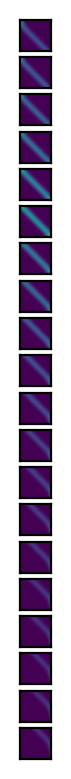

In [15]:
fig, axes = plt.subplots(nrows=n_velocity)
for i, ax in enumerate(axes):
    img = transition_position_pvp[:, i, :]
    ax.imshow(img, aspect=1)
    ax.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

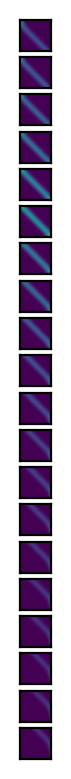

In [16]:
transition_position_ppv = np.swapaxes(transition_position_pvp, 1, 2) # p, v, p => p, p, v

fig, axes = plt.subplots(nrows=n_velocity)
for i, ax in enumerate(axes):
    img = transition_position_ppv[:, :, i]
    ax.imshow(img, aspect=1)
    ax.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
# np.swapaxes(transition_position, 1, 2)

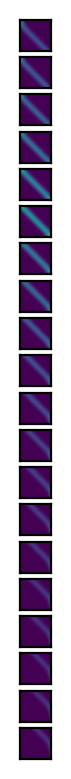

In [17]:
transition_position_vpp = np.swapaxes(transition_position_pvp, 1, 0) # p, v, p => v, p, p

fig, axes = plt.subplots(nrows=n_velocity)
for i, ax in enumerate(axes):
    img = transition_position_vpp[i, :, :]
    ax.imshow(img, aspect=1)
    ax.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
# np.swapaxes(transition_position, 1, 2)

# Running the environment

In [18]:
all_hist_pos = {}
all_hist_vel = {}

n_sample_run = 20

policies = ["all-one", "all-zero", "random", "max-expected-velocity"]
for policy in policies:

    hist_pos = np.zeros((n_sample_run, n_timestep))
    hist_vel = np.zeros_like(hist_pos)

    for sample in range(n_sample_run):

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin()    # Something close to 0

        np.random.seed(123 + sample*123)

        for t_idx, t in enumerate(timestep):

            if policy == "all-one":
                a = 1
            elif policy == "all-zero":
                a = 0
            elif policy == "random":
                a = np.random.choice([0, 1])
            elif policy == "max-expected-velocity":
                e_v = np.zeros(2)
                for a in range(2):
                    e_v[a] = np.average(velocity, weights=transition_velocity_tvav[t_idx, v_idx, a, :])
                a = e_v.argmax()
            else:
                raise ValueError

            v_idx = np.random.choice(np.arange(n_velocity), p=transition_velocity_tvav[t_idx, v_idx, a, :]) #= np.average(velocity, weights=p_)
            pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

            hist_pos[sample, t_idx] = position[pos_idx]
            hist_vel[sample, t_idx] = velocity[v_idx]

        all_hist_pos[policy] = hist_pos
        all_hist_vel[policy] = hist_vel

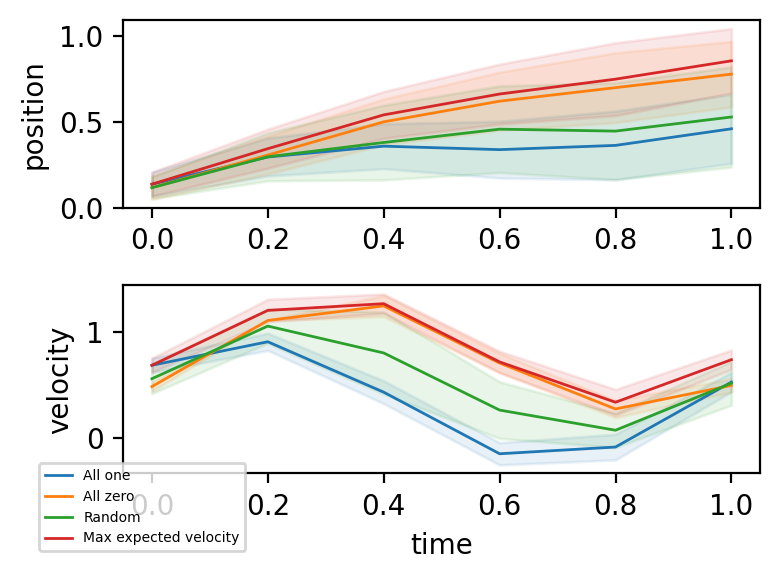

In [19]:
def plot_runs(policies, all_hist_pos, all_hist_vel):
    fig, axes = plt.subplots(nrows=2, figsize=(4, 3))
    for i, policy in enumerate(policies):
        label = policy.replace("-", " ").capitalize()
        pos = all_hist_pos[policy].mean(axis=0)
        pos_disp = all_hist_pos[policy].std(axis=0)
        vel = all_hist_vel[policy].mean(axis=0)
        vel_disp = all_hist_vel[policy].std(axis=0)
        x = np.linspace(0, 1, n_timestep)
        if label.startswith("Af"):
            label = label.replace("Af", "Active inference -")
            linewidth = 2
            if label.endswith("epistemic"):
                linestyle = ":"
                linewidth = 4
            elif label.endswith("pragmatic"):
                linestyle = "-."
            else:
                label = label.replace(" -", "")
                linestyle = "--"
        else:
            linestyle, linewidth = "-", 1
        axes[0].plot(x, pos, color=f"C{i}", label=label, linestyle=linestyle, linewidth=linewidth)
        axes[0].fill_between(x, pos - pos_disp, pos + pos_disp, alpha=0.1, color=f"C{i}")
        axes[1].plot(x, vel, color=f"C{i}", linestyle=linestyle, linewidth=linewidth)
        axes[1].fill_between(x, vel - vel_disp, vel + vel_disp, alpha=0.1, color=f"C{i}")
        axes[0].set_ylabel("position")
        axes[1].set_ylabel("velocity")
        axes[1].set_xlabel("time")

    fig.legend(loc=[0.05, 0.05], fontsize=5)
    fig.tight_layout()

plot_runs(policies, all_hist_pos, all_hist_vel)

## Preferences (biased prior on the position)

In [20]:
target = 1.0
tolerance = 0.5

# Compute log prior
p = norm.cdf(position, loc=target, scale=tolerance)
p /= p.sum()
log_prior = np.log(p)

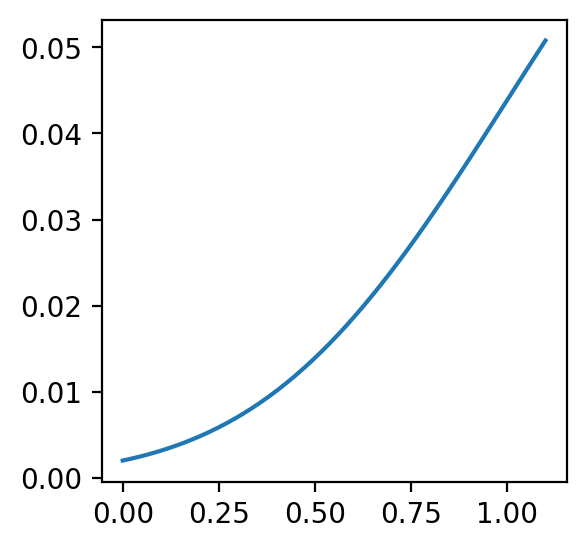

In [21]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(position, p);

## Helper functions

In [22]:
def kl_div_dirichlet(alpha_coeff, beta_coeff):
    """
        https://statproofbook.github.io/P/dir-kl.html
    """
    alpha_0 = np.sum(alpha_coeff)
    beta_0 = np.sum(beta_coeff)
    kl = (
        gammaln(alpha_0)
        - gammaln(beta_0)
        - np.sum(gammaln(alpha_coeff))
        + np.sum(gammaln(beta_coeff))
        + np.sum((alpha_coeff - beta_coeff) * (digamma(alpha_coeff) - digamma(alpha_0)))
    )
    return kl

# Pragmatic values: demonstrate that it works for one timestep

In [23]:
v_idx = 2
pos_idx = 11
t_idx = 5

qv = np.zeros(n_velocity)
qv[v_idx] = 1.
qp = np.zeros(n_position)
qp[pos_idx] = 1.


qvs = np.zeros((n_action, n_velocity))
qps = np.zeros((n_action, n_position))
for action_idx, a in enumerate(range(n_action)):

    qv_new = qv @ transition_velocity_tvav[t_idx, :, a, :]
    qp_new = qp @ (qv_new @ transition_position_pvp)
    qvs[action_idx] = qv_new
    qps[action_idx] = qp_new

pragmatic = np.sum(qps * log_prior, axis=1)
print("pragmatic values", pragmatic)

e_v = np.zeros(2)
for i in range(2):
    e_v[i] = np.average(velocity, weights=transition_velocity_tvav[t_idx, v_idx, i, :])
print("expected velocities", e_v)

pragmatic values [-5.13248639 -4.96848993]
expected velocities [0.04842105 0.31438596]


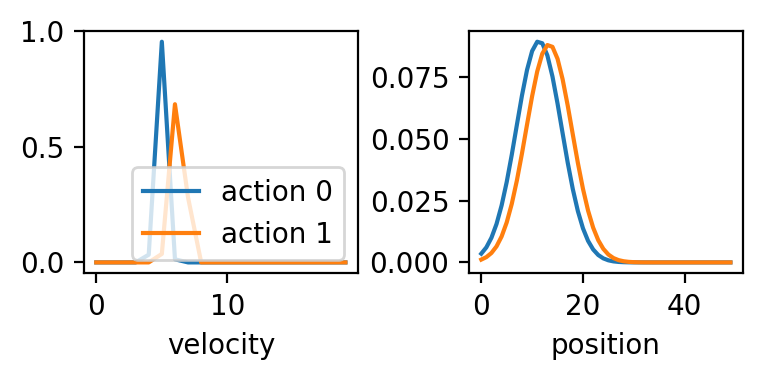

In [24]:
fig, axes = plt.subplots(figsize=(4, 2), ncols=2)

ax = axes[0]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(qvs[action_idx], label=f"action {a}")

ax.set_xlabel("velocity")
ax.legend(loc="lower right")

ax = axes[1]
for action_idx, a in enumerate(range(n_action)):
    ax.plot(qps[action_idx], label=f"action {a}")

ax.set_xlabel("position")
plt.tight_layout()

# Pragmatic values: demonstrate that it works for a run

In [25]:
horizon = 6

# For logs
hist_pos, hist_vel = np.zeros((n_sample_run, n_timestep)), np.zeros((n_sample_run, n_timestep))

# For each sample...
for sample in range(n_sample_run):

    pos_idx = np.absolute(position).argmin()  # Something close to 0
    v_idx = np.absolute(velocity).argmin() # Something close to 0

    np.random.seed(123 + sample*123)

    for t_idx in range(n_timestep):

        h = min(horizon, n_timestep - t_idx)
        action_plan = list(itertools.product(range(n_action), repeat=h))

        pragmatic = np.zeros(len(action_plan))
        for ap_index, ap in enumerate(action_plan):

            qvs = np.zeros((h, n_velocity))
            qps = np.zeros((h, n_position))

            qv = np.zeros(n_velocity)
            qv[v_idx] = 1.
            qp = np.zeros(n_position)
            qp[pos_idx] = 1.

            for h_idx in range(h):
                a = ap[h_idx]
                rollout_t_index = t_idx + h_idx  # TODO: think about always using a fix horizon => using modulo
                qv= qv @ transition_velocity_tvav[rollout_t_index, :, a, :]
                qp = qp @ (qv @ transition_position_pvp)
                qvs[h_idx] = qv
                qps[h_idx] = qp

            pragmatic[ap_index] = np.sum(qps @ log_prior)

        a = action_plan[np.argmax(pragmatic)][0]

        v_idx = np.random.choice(np.arange(n_velocity), p=transition_velocity_tvav[t_idx, v_idx, a, :])
        pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

        hist_pos[sample, t_idx] = position[pos_idx]
        hist_vel[sample, t_idx] = velocity[v_idx]

policy = "af-pragmatic"
if policy not in policies:
    policies.append(policy)
all_hist_pos[policy] = hist_pos
all_hist_vel[policy] = hist_vel


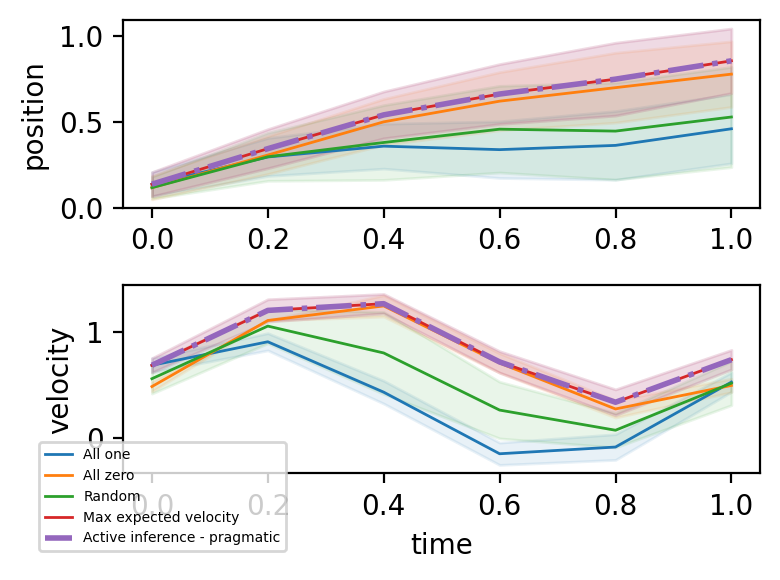

In [26]:
plot_runs(policies, all_hist_pos, all_hist_vel)

# Epistemic value

In [27]:
def q_transition_velocity(alpha):
    sum_col = np.sum(alpha, axis=-1)
    sum_col[sum_col <= 0.] = 1
    return alpha / sum_col[:, : ,:,np.newaxis]

In [28]:
all_hist_err = {}
policies_err = []

In [43]:
n_episode = 200
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    alpha_tvav = np.zeros((n_timestep, n_velocity, n_action, n_velocity)) + np.finfo(np.float64).eps

    if sample == 0:
        error = np.sum(np.absolute(transition_velocity_tvav - q_transition_velocity(alpha_tvav)))
        print(f"Initial error {error:.2f}")

    epoch = 0
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin() # Something close to 0

        action_plan = np.random.randint(n_action, size=n_timestep)

        for t_idx, t in enumerate(timestep):

            # Pick new action and draw new velocity
            a = action_plan[t_idx]
            new_v_index = np.random.choice(np.arange(n_velocity), p=transition_velocity_tvav[t_idx, v_idx, a, :])

            # Update alpha
            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tvav[t_idx, v_idx, a, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.sum(np.absolute(transition_velocity_tvav - q_transition_velocity(alpha_tvav)))
            hist_err[sample, epoch] = error
            epoch += 1

    print(f"[Sample {sample}] Error after {epoch} epochs {error:.2f}")

policy = "random"
if policy not in policies_err:
    policies_err.append(policy)
all_hist_err[policy] = hist_err

Initial error 426.67
[Sample 0] Error after 1200 epochs 350.03
[Sample 1] Error after 1200 epochs 346.74
[Sample 2] Error after 1200 epochs 349.52
[Sample 3] Error after 1200 epochs 346.93
[Sample 4] Error after 1200 epochs 343.75
[Sample 5] Error after 1200 epochs 345.20
[Sample 6] Error after 1200 epochs 344.53
[Sample 7] Error after 1200 epochs 342.52
[Sample 8] Error after 1200 epochs 340.95
[Sample 9] Error after 1200 epochs 343.35
[Sample 10] Error after 1200 epochs 341.09
[Sample 11] Error after 1200 epochs 345.39
[Sample 12] Error after 1200 epochs 345.60
[Sample 13] Error after 1200 epochs 344.93
[Sample 14] Error after 1200 epochs 346.58
[Sample 15] Error after 1200 epochs 344.12
[Sample 16] Error after 1200 epochs 349.98
[Sample 17] Error after 1200 epochs 347.75
[Sample 18] Error after 1200 epochs 346.76
[Sample 19] Error after 1200 epochs 347.87


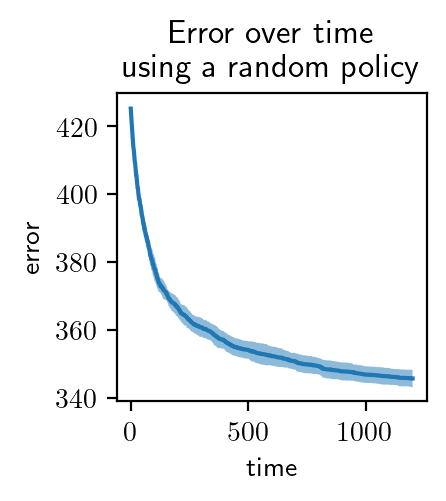

In [45]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(hist_err.mean(axis=0))
ax.fill_between(np.arange(n_episode*n_timestep),
                hist_err.mean(axis=0) - hist_err.std(axis=0),
                hist_err.mean(axis=0) + hist_err.std(axis=0),
                alpha=0.5)
ax.set_xlabel("time")
ax.set_ylabel("error")
ax.set_title("Error over time\nusing a random policy");

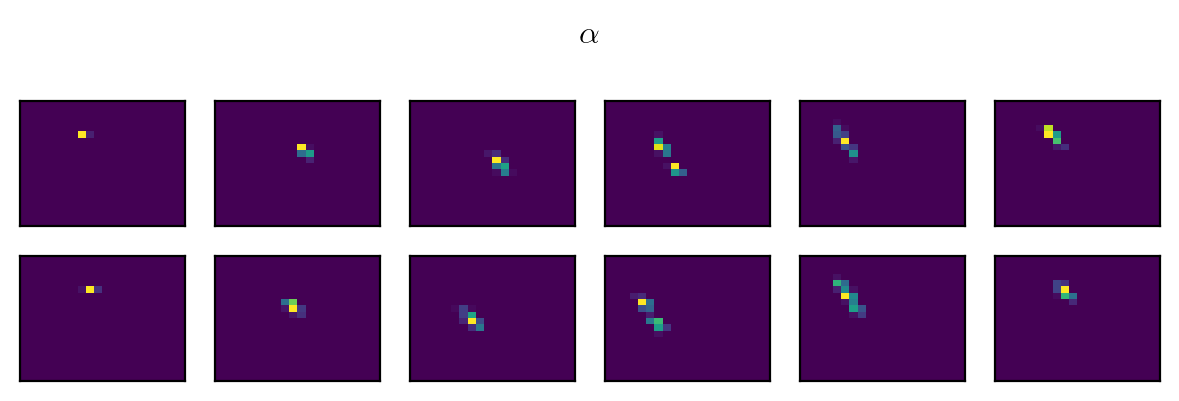

In [35]:
plt.rcParams['text.usetex'] = True

fig, axes = plt.subplots(ncols=n_timestep, nrows=n_action, figsize=(6, 2))
fig.suptitle(r"$\alpha$")
for a_idx in range(n_action):
    for t_idx in range(n_timestep):
        ax = axes[a_idx, t_idx]
        img = alpha_tvav[t_idx, :, a_idx, :]
        ax.imshow(img, aspect="auto")
        ax.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

fig.tight_layout()

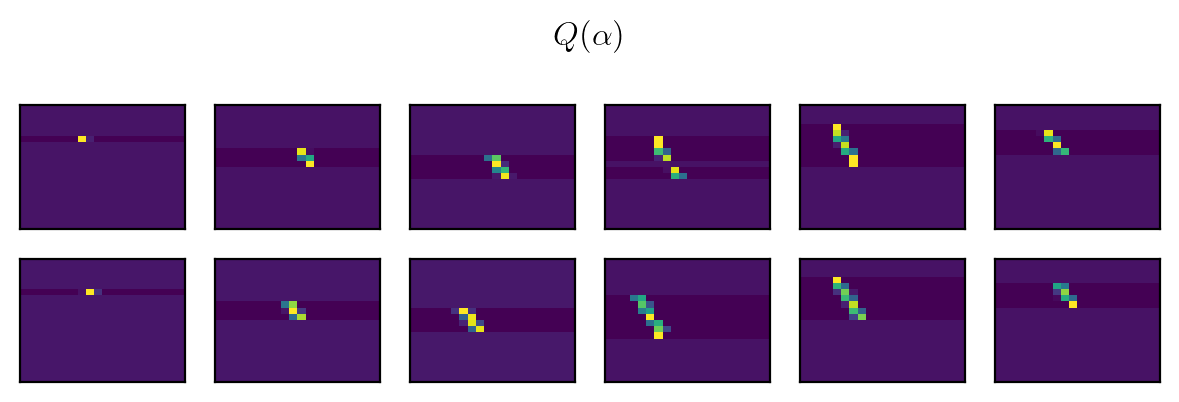

In [37]:
q = q_transition_velocity(alpha_tvav)

plt.rcParams['text.usetex'] = True
fig, axes = plt.subplots(ncols=n_timestep, nrows=n_action, figsize=(6, 2))
fig.suptitle(r"$Q(\alpha)$")
for a_idx in range(n_action):
    for t_idx in range(n_timestep):
        ax = axes[a_idx, t_idx]
        img = q[t_idx, :, a_idx, :]
        ax.imshow(img, aspect="auto")
        ax.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

fig.tight_layout()

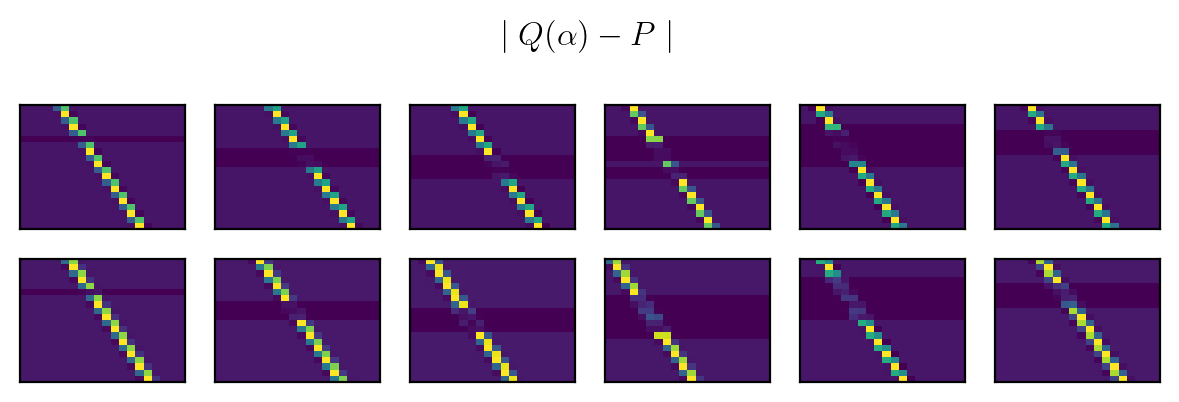

In [39]:
q = q_transition_velocity(alpha_tvav)
diff = np.absolute(transition_velocity_tvav - q)

plt.rcParams['text.usetex'] = True
fig, axes = plt.subplots(ncols=n_timestep, nrows=n_action, figsize=(6, 2))
fig.suptitle(r"$\mid Q(\alpha) - P \mid$")
for a_idx in range(n_action):
    for t_idx in range(n_timestep):
        ax = axes[a_idx, t_idx]
        img = diff[t_idx, :, a_idx, :]
        ax.imshow(img, aspect="auto")
        ax.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])

fig.tight_layout()

In [48]:
n_episode = 200
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))

for sample in range(n_sample_run):

    # Initialize alpha
    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).tiny + 0.01

    # Log error
    error = np.sum(np.absolute(transition_velocity_tvav - q_transition_velocity(alpha_tvav)))
    if sample == 0:
        print("Initial error", error)

    hist_a = []
    epoch = 0

    # with tqdm(total=n_episode) as pbar:
    for ep_idx in range(n_episode):

        np.random.seed(12334 + ep_idx + sample * 123)

        pos_idx = np.absolute(position).argmin()  # Something close to 0
        v_idx = np.absolute(velocity).argmin() # Something close to 0

        for t_idx, t in enumerate(timestep):

            h = min(horizon, n_timestep - t_idx)
            action_plan = list(itertools.product(range(n_action), repeat=h))

            pragmatic = np.zeros(len(action_plan))

            # Initialize action plan values
            epistemic = np.zeros(len(action_plan))

            q = q_transition_velocity(alpha_tavv)

            # Compute value of each action plan
            for ap_index, ap in enumerate(action_plan):

               # Initialize the rollout model (= counts)
                alpha_tavv_rollout = alpha_tavv.copy()

                qv = np.zeros(n_velocity)
                qv[v_idx] = 1.

                for h_idx, a in enumerate(ap):

                   # Update rollout time index
                    rollout_t_index = t_idx + h_idx

                    # Update beliefs about the transition model     = > (N, 1)
                    alpha_tavv_rollout[rollout_t_index,  a, :, :] += qv[:, np.newaxis] * q[rollout_t_index, a, :, :]

                    # Update beliefs about the velocity and position [IMPORTANT] => do it after updating beliefs about the transitions
                    qv = qv @ q[rollout_t_index, a, :, :]

                    # Choose the best action plan
                epistemic[ap_index] = kl_div_dirichlet(alpha_tavv_rollout, alpha_tavv)

            # Choose the best action plan
            best_action_plan_index = np.random.choice(np.arange(len(action_plan))[epistemic == epistemic.max()])
            a = action_plan[best_action_plan_index][0]

            new_v_index = np.random.choice(n_velocity, p=transition_velocity_tavv[t_idx, a, v_idx, :])

            # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
            alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

            # Update velocity and position
            v_idx = new_v_index
            pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

            # Log
            error = np.sum(np.absolute(transition_velocity_tavv - q_transition_velocity(alpha_tavv)))
            hist_err[sample, epoch] = error
            hist_a.append(a)
            epoch += 1

            # pbar.set_postfix(error=f"{error:.2f}")
            # pbar.update(1)

    print(f"[Sample {sample}] Error after {epoch} epochs: {error:.2f}")

    print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

policy = "af-epistemic"
if policy not in policies_err:
    policies_err.append(policy)
all_hist_err[policy] = hist_err

Initial error 347.87358924550597
[Sample 0] Error after 1200 epochs: 341.22
[Sample 0] Freq choose action 0: 50.67%
[Sample 1] Error after 1200 epochs: 343.34
[Sample 1] Freq choose action 0: 49.33%
[Sample 2] Error after 1200 epochs: 341.04
[Sample 2] Freq choose action 0: 50.42%
[Sample 3] Error after 1200 epochs: 339.98
[Sample 3] Freq choose action 0: 51.75%
[Sample 4] Error after 1200 epochs: 341.22
[Sample 4] Freq choose action 0: 49.25%
[Sample 5] Error after 1200 epochs: 339.07
[Sample 5] Freq choose action 0: 50.08%
[Sample 6] Error after 1200 epochs: 339.46
[Sample 6] Freq choose action 0: 51.25%
[Sample 7] Error after 1200 epochs: 341.87
[Sample 7] Freq choose action 0: 50.58%
[Sample 8] Error after 1200 epochs: 340.90
[Sample 8] Freq choose action 0: 50.25%
[Sample 9] Error after 1200 epochs: 343.06
[Sample 9] Freq choose action 0: 50.00%
[Sample 10] Error after 1200 epochs: 340.07
[Sample 10] Freq choose action 0: 48.33%
[Sample 11] Error after 1200 epochs: 345.51
[Sample 

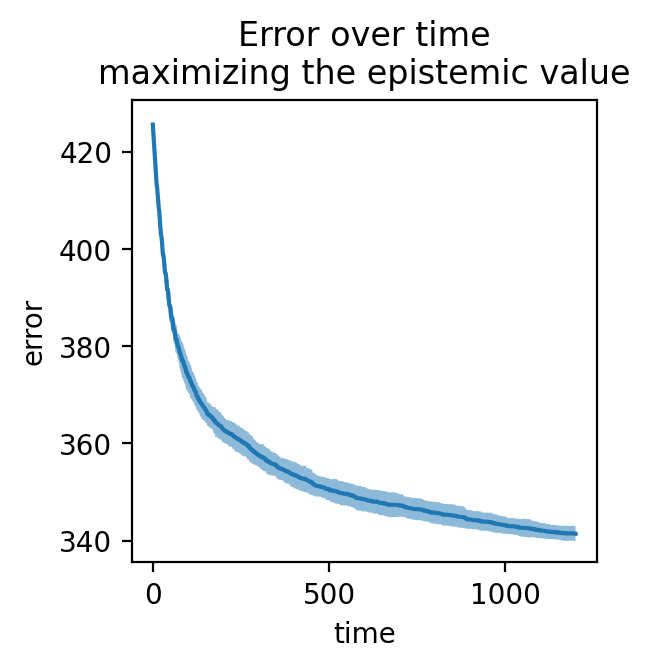

In [49]:
plt.rcParams['text.usetex'] = False
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(hist_err.mean(axis=0));
ax.fill_between(np.arange(len(hist_err.mean(axis=0))), hist_err.mean(axis=0) - hist_err.std(axis=0), hist_err.mean(axis=0) + hist_err.std(axis=0), alpha=0.5);
ax.set_xlabel("time")
ax.set_ylabel("error")
ax.set_title("Error over time\nmaximizing the epistemic value");

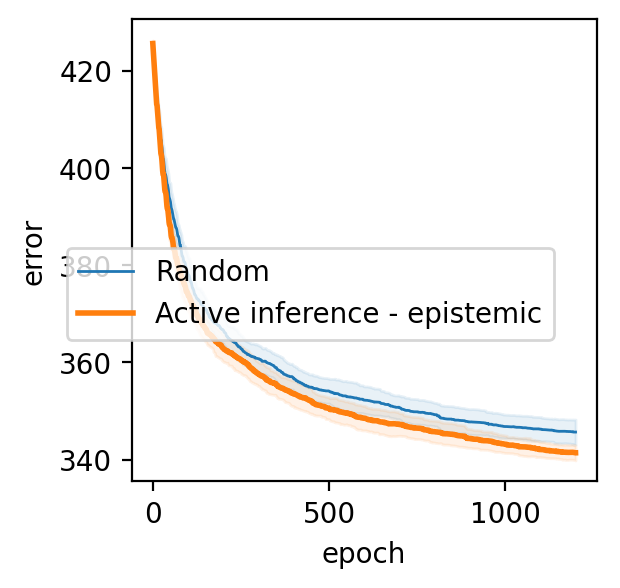

In [50]:
fig, ax = plt.subplots(figsize=(3, 3))
for i, policy in enumerate(policies_err):
    label = policy.replace("-", " ").capitalize()
    hist_err_mean = all_hist_err[policy].mean(axis=0)
    x = np.arange(len(hist_err_mean))
    hist_err_std = all_hist_err[policy].std(axis=0)

    if label.startswith("Af"):
        label = label.replace("Af", "Active inference -")
        linestyle, linewidth = "-", 2
    else:
        linestyle, linewidth = "-", 1
    ax.plot(x, hist_err_mean, color=f"C{i}", label=label, linestyle=linestyle, linewidth=linewidth)
    ax.fill_between(x, hist_err_mean - hist_err_std, hist_err_mean + hist_err_std, alpha=0.1, color=f"C{i}")
    ax.set_ylabel("error")
    ax.set_xlabel("epoch")

fig.legend(loc="center");

# All together

In [53]:
n_episode = 400
n_sample_run = 20
hist_err = np.zeros((n_sample_run, n_episode*n_timestep))
hist_pos = np.zeros((n_sample_run, n_episode, n_timestep))
hist_vel = np.zeros((n_sample_run, n_episode, n_timestep))

for sample in range(n_sample_run):

    alpha_tavv = np.zeros((n_timestep, n_action, n_velocity, n_velocity)) + np.finfo(np.float64).tiny + 0.01

    error = np.sum(np.absolute(transition_velocity_tavv - q_transition_velocity(alpha_tavv)))
    if sample == 0:
        print(f"Initial error {error:.2f}")

    hist_a = []
    epoch = 0

    with tqdm(total=n_episode) as pbar:
        for ep_idx in range(n_episode):

            np.random.seed(12334 + ep_idx + sample * 123)

            pos_idx = np.absolute(position).argmin()  # Something close to 0
            v_idx = np.absolute(velocity).argmin() # Something close to 0

            for t_idx, t in enumerate(timestep):

                h = min(horizon, n_timestep - t_idx)
                action_plan = list(itertools.product(range(n_action), repeat=h))
                n_action_plan = len(action_plan)

                # Initialize action plan values
                pragmatic = np.zeros(n_action_plan)
                epistemic = np.zeros(n_action_plan)

                q = q_transition_velocity(alpha_tavv)

                # Compute value of each action plan
                for ap_index, ap in enumerate(action_plan):

                    # Initialize the rollout model
                    alpha_tavv_rollout = alpha_tavv.copy()
                    qv = np.zeros(n_velocity)
                    qv[v_idx] = 1.
                    qps = np.zeros((h, n_position))
                    qp = np.zeros(n_position)
                    qp[pos_idx] = 1.

                    for h_idx, a in enumerate(ap):

                        # Update rollout time index
                        rollout_t_index = t_idx + h_idx

                        # Update beliefs about the transition model
                        alpha_tavv_rollout[rollout_t_index,  a, :, :] += qv[:, np.newaxis] * q[rollout_t_index, a, :, :]

                        # Update beliefs about the velocity and position [IMPORTANT: doing this after updating the transition model]
                        qv = qv @ q[rollout_t_index, a, :, :]
                        qp = qp @ (qv @ transition_position_pvp)
                        qps[h_idx] = qp

                    # Compute the pragmatic value of the action plan
                    pragmatic[ap_index] = np.sum(qps @ log_prior)

                    # Compute the KL divergence between the model after the rollout and the current model
                    epistemic[ap_index] = kl_div_dirichlet(alpha_tavv_rollout, alpha_tavv)

                val = pragmatic + epistemic
                best_action_plan_indexes = np.arange(n_action_plan)[val == val.max()]
                selected_action_plan_idx = np.random.choice(best_action_plan_indexes)
                a = action_plan[selected_action_plan_idx][0]

                new_v_index = np.random.choice(n_velocity, p=transition_velocity_tavv[t_idx, a, v_idx, :])

                # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
                alpha_tavv[t_idx, a, v_idx, new_v_index] += 1

                # Update velocity and position
                v_idx = new_v_index
                pos_idx = np.random.choice(n_position, p=transition_position_pvp[pos_idx, v_idx, :])

                # Log
                error = np.sum(np.absolute(transition_velocity_tavv - q_transition_velocity(alpha_tavv)))
                hist_err[sample, epoch] = error
                hist_pos[sample, ep_idx, t_idx] = position[pos_idx]
                hist_vel[sample, ep_idx, t_idx] = velocity[v_idx]
                hist_a.append(a)
                epoch += 1

            pbar.set_description(f"[Sample {sample}] [Episode {ep_idx}]")
            pbar.set_postfix(error=f"{error:.2f}", position=f"{position[pos_idx]:.2f}")
            pbar.update(1)

        print(f"[Sample {sample}] Error after {epoch} epochs: {error:.2f}")
        print(f"[Sample {sample}] Freq choose action 0: {100*hist_a.count(0)/len(hist_a):.2f}%")

policy = "af"
if policy not in policies:
    policies.append(policy)
if policy not in policies_err:
    policies_err.append(policy)
all_hist_err[policy] = hist_err
all_hist_pos[policy] = hist_pos[:, -1, :] # Keep only the last episode
all_hist_vel[policy] = hist_vel[:, -1, :] # Keep only the last episode

Initial error 426.67


[Sample 0] [Episode 399]: 100%|██████████| 400/400 [00:12<00:00, 31.19it/s, error=344.45, position=0.49]


[Sample 0] Error after 2400 epochs: 344.45
[Sample 0] Freq choose action 0: 53.62%


[Sample 1] [Episode 399]: 100%|██████████| 400/400 [00:12<00:00, 30.97it/s, error=342.41, position=1.06]


[Sample 1] Error after 2400 epochs: 342.41
[Sample 1] Freq choose action 0: 53.58%


[Sample 2] [Episode 399]: 100%|██████████| 400/400 [00:12<00:00, 30.77it/s, error=345.50, position=0.83]


[Sample 2] Error after 2400 epochs: 345.50
[Sample 2] Freq choose action 0: 53.08%


[Sample 3] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 29.35it/s, error=344.66, position=1.03]


[Sample 3] Error after 2400 epochs: 344.66
[Sample 3] Freq choose action 0: 53.25%


[Sample 4] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 29.84it/s, error=343.22, position=0.63]


[Sample 4] Error after 2400 epochs: 343.22
[Sample 4] Freq choose action 0: 53.12%


[Sample 5] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.27it/s, error=348.89, position=0.92]


[Sample 5] Error after 2400 epochs: 348.89
[Sample 5] Freq choose action 0: 53.62%


[Sample 6] [Episode 399]: 100%|██████████| 400/400 [00:12<00:00, 30.88it/s, error=341.64, position=0.65]


[Sample 6] Error after 2400 epochs: 341.64
[Sample 6] Freq choose action 0: 53.67%


[Sample 7] [Episode 399]: 100%|██████████| 400/400 [00:12<00:00, 30.84it/s, error=351.12, position=0.65]


[Sample 7] Error after 2400 epochs: 351.12
[Sample 7] Freq choose action 0: 52.75%


[Sample 8] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.23it/s, error=352.29, position=0.36]


[Sample 8] Error after 2400 epochs: 352.29
[Sample 8] Freq choose action 0: 53.83%


[Sample 9] [Episode 399]: 100%|██████████| 400/400 [00:12<00:00, 30.82it/s, error=345.78, position=0.81]


[Sample 9] Error after 2400 epochs: 345.78
[Sample 9] Freq choose action 0: 52.58%


[Sample 10] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.43it/s, error=349.89, position=0.72]


[Sample 10] Error after 2400 epochs: 349.89
[Sample 10] Freq choose action 0: 53.38%


[Sample 11] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.35it/s, error=341.74, position=0.74]


[Sample 11] Error after 2400 epochs: 341.74
[Sample 11] Freq choose action 0: 53.29%


[Sample 12] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.49it/s, error=344.23, position=1.08]


[Sample 12] Error after 2400 epochs: 344.23
[Sample 12] Freq choose action 0: 53.42%


[Sample 13] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.43it/s, error=353.37, position=0.79]


[Sample 13] Error after 2400 epochs: 353.37
[Sample 13] Freq choose action 0: 53.42%


[Sample 14] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.42it/s, error=354.58, position=1.06]


[Sample 14] Error after 2400 epochs: 354.58
[Sample 14] Freq choose action 0: 53.58%


[Sample 15] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.30it/s, error=351.18, position=1.06]


[Sample 15] Error after 2400 epochs: 351.18
[Sample 15] Freq choose action 0: 53.04%


[Sample 16] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.42it/s, error=347.01, position=0.72]


[Sample 16] Error after 2400 epochs: 347.01
[Sample 16] Freq choose action 0: 53.58%


[Sample 17] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.29it/s, error=347.31, position=1.08]


[Sample 17] Error after 2400 epochs: 347.31
[Sample 17] Freq choose action 0: 53.46%


[Sample 18] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.36it/s, error=346.93, position=0.88]


[Sample 18] Error after 2400 epochs: 346.93
[Sample 18] Freq choose action 0: 53.75%


[Sample 19] [Episode 399]: 100%|██████████| 400/400 [00:13<00:00, 30.47it/s, error=349.56, position=1.03]

[Sample 19] Error after 2400 epochs: 349.56
[Sample 19] Freq choose action 0: 53.46%


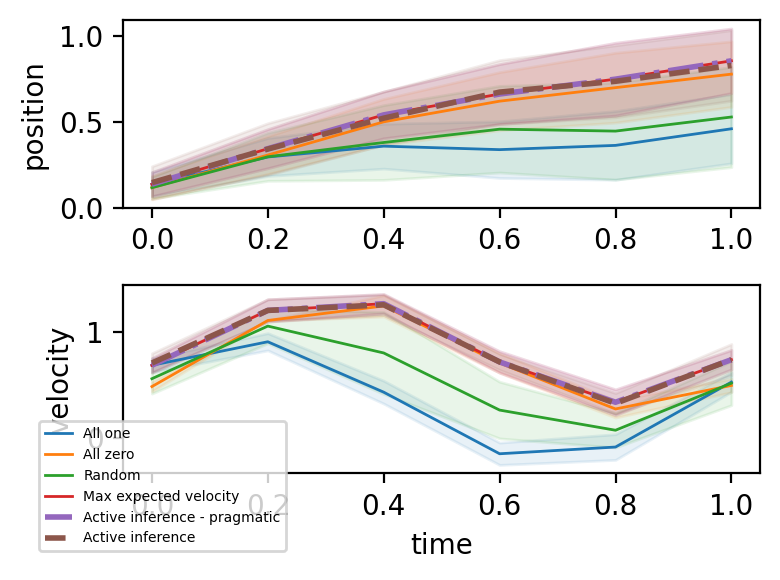

In [39]:
plot_runs(policies, all_hist_pos, all_hist_vel)

# Possible extensions

    - Always using a fix horizon (modulo the beginning of the episode)
    - Pretraining the model
    - Using a couple of different generative models
    - Add meaninful priors (e.g. night)
    - Add the current position as a predictor of the velocity

In [ ]:
    # # ---- Pre-training ----
    #
    # epoch = 0
    # for idx_ep in tqdm(range(n_episode_pre_train)):
    #
    #     np.random.seed(12334 + idx_ep)
    #
    #     pos_idx = np.absolute(position).argmin()  # Something close to 0
    #     v_idx = np.absolute(velocity).argmin() # Something close to 0
    #
    #     action_plan = np.random.randint(n_action, size=n_timestep)
    #
    #     for ap_index in range(len(action_plan)):
    #
    #         a = action_plan[t_idx]
    #         new_v_index = np.random.choice(np.arange(n_velocity), p=transition_velocity_tvav[t_idx, v_idx, a, :])
    #
    #         # https://blog.jakuba.net/posterior-predictive-distribution-for-the-dirichlet-categorical-model/
    #         alpha_tvav[t_idx, v_idx, a, new_v_index] += 1
    #
    #         # print("v_idx", v_idx, "new_v_index", new_v_index)
    #
    #         # Update velocity and position
    #         v_idx = new_v_index
    #         pos_idx = np.random.choice(np.arange(n_position), p=transition_position_pvp[pos_idx, v_idx, :])
    #
    #         # Log
    #         error = np.sum(np.absolute(transition_velocity_tvav - q_transition_velocity(alpha_tvav)))
    #         hist_err.append(error)
    #         epoch += 1

    # print(f"Error after {epoch} epochs, before learning: {error}")